In [8]:
import numpy as numpy
import cv2
import glob
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
import random

### 11.1.1 Prepare Real Image

In [9]:
#List all filename in art image path
img_size = (32, 32, 3)
filenames= glob.glob("./week12_dataset/Abstract_gallery/Abstract_gallery/*")
print(len(filenames))

# train_dataset # read image from dataset and resize to train_dataset.shape = img_size using interpolation="bilinear"
images = []
for path in filenames:
    image = cv2.imread(path)     
    image = cv2.resize(image, dsize=((32, 32)))
    image = (image - 127.5) / 127.5
    images.append(image)

images = numpy.array(images)
print(images.shape)
# # rescale train_dataset values [0, 255] -> [-1, 1]

2782
(2782, 32, 32, 3)


In [10]:
print(images[0])

[[[-0.85882353 -0.85098039 -0.88235294]
  [-0.77254902 -0.56862745 -0.57647059]
  [-0.99215686 -0.94509804 -0.85882353]
  ...
  [ 0.14509804  0.19215686  0.12941176]
  [ 0.19215686  0.27058824  0.16862745]
  [ 0.31764706  0.54509804  0.57647059]]

 [[-0.94509804 -0.78039216 -0.77254902]
  [-0.88235294 -0.79607843 -0.81176471]
  [-0.8745098  -0.6        -0.49019608]
  ...
  [ 0.40392157  0.33333333  0.12156863]
  [ 0.25490196  0.28627451  0.10588235]
  [ 0.35686275  0.58431373  0.61568627]]

 [[-0.84313725 -0.83529412  0.28627451]
  [-0.83529412 -0.77254902  0.44313725]
  [-0.76470588 -0.80392157  0.43529412]
  ...
  [ 0.35686275  0.25490196  0.05882353]
  [ 0.30196078  0.3254902   0.20784314]
  [ 0.39607843  0.61568627  0.62352941]]

 ...

 [[ 0.56078431  0.75686275  0.71764706]
  [-0.29411765 -0.41176471 -0.74901961]
  [ 0.18431373  0.04313725 -0.27058824]
  ...
  [-0.19215686  0.18431373  0.11372549]
  [-0.1372549   0.22352941  0.16078431]
  [ 0.01176471  0.09803922  0.00392157]]

 [

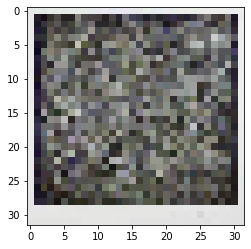

In [11]:
# # Random Selected images
def generate_real_samples(dataset, n_samples):
  ix = numpy.random.randint(0, dataset.shape[0], n_samples) # random image index
  # retrieve selected images
  # print(ix)
  X = dataset[ix] # get image from random pick ix
  # generate y = 1 for 'real' class labels
  y = numpy.random.randint(1, 2, size=(n_samples, 1)) #-> (y.shape = (n_samples,1))
  return X, y

n_samples = 10
# # Display Random Real Images
X_real, y_real = generate_real_samples(images, n_samples)
# imshow(X_real) # convert dtype to uint8
tmp = X_real[0] * 127.5 + 127.5
plt.imshow(tmp.astype('uint8'))

### 11.1.2 Prepare Fake Image initial for training discriminator(D)

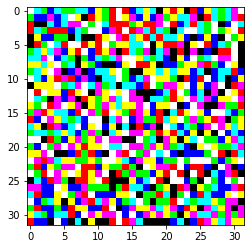

In [12]:
def generate_fake_samples(n_samples, target_size=(32,32,3)):
  h,w,c = target_size
  # generate 1D uniform random numbers in [0,1]
  X = numpy.random.randint(0, 2, size=(n_samples * h * w * 3)) #-> X.shape = (n_samples * h * w * 3)
  # rescale X value from [0, 1] to [-1, 1]
  X = (X - 0.5) / 0.5 # Xmax = 1, Xmin = -1
  # reshape X from 1D to 4D
  X = numpy.reshape(X, (n_samples, h, w, c)) # X.shape = (n_samples, h, w, c)
  # generate y = 0 for 'fake' class label
  y = numpy.random.randint(1, size=(n_samples, 1))# y.shape = (n_samples,1)
  return X, y

X_fake, y_fake = generate_fake_samples(n_samples)
tmp = X_fake[0] * 127.5 + 127.5
plt.imshow(tmp.astype('uint8'))

#### 11.2.1 Create Discriminator Model (D) and Training

In [13]:
# Discriminator Model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
  return model

Create Discriminator Model (D) and Training

In [14]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=60, n_batch=128, target_size=(32,32,3)):
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_iter):
  # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)
    # generate 'fake' examples
    X_fake, y_fake = generate_fake_samples(half_batch, target_size=img_size)
    # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    # summarize performance
    # print(real_acc, fake_acc)

#### 11.2.1 Create Model and pre-train Discriminator (D)

In [15]:
# define model
d_model = define_discriminator(img_size)
# summarize the model
d_model.summary()
# Training Discriminator
train_discriminator(d_model, images, target_size = img_size)

/Users/thana/Workspace/Class/image/env/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

2022-04-19 16:57:23.900197: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


#### 11.2.2 Create Generator Model (G)

In [16]:
# define the standalone generator model
def define_generator(latent_dim, discr_out = (256,4,4)):
  model = Sequential()
  # foundation for 4x4 image
  c, w, h = discr_out
  n_nodes = c * w * h
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((w, h, c)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

#### Create Model and pre-train Discriminator (D)

In [17]:
# define the generator model
g_model = define_generator(100)
# summarize the model
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

#### 11.2.3 Create GAN Model (G,D) and Training

In [18]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

#### 11.2.3 Create GAN Model (G,D) and Training

In [19]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = numpy.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [20]:
# update generate fake image using generator prediction
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create 'fake' class labels (0)
  y = numpy.random.randint(1, size=(n_samples, 1))# y = 0 with shape (n_sample, )
  return X, y

#### 11.2.3 Create GAN Model (G,D) and Training

In [33]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
      for j in range(bat_per_epo):
      # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        d_loss1, _ = d_model.train_on_batch(X_real, y_real) # update discriminator model weights
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_loss2, _ = d_model.train_on_batch(X_fake, y_fake) # update discriminator model weights
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = numpy.ones((n_batch, 1)) # create inverted labels for the fake samples y = 0 with shape (n_batch, )
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        print(d_loss1, d_loss2, g_loss) # summarize loss on this batch
        # evaluate the model performance, every Nepoch
      if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)
          
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(acc_real , acc_fake)
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'new_generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

In [ ]:
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

train(g_model, d_model, gan_model, images, 100, 100)

In [126]:
def save_plot(examples, epoch, n=10):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		tmp = (examples[i, :, :, :]) 
		tmp = tmp * 127.5 + 127.5
		plt.imshow(tmp)
	filename = 'new_generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [125]:
x_fake, y_fake = generate_fake_samples(g_model, 100, 200)
n = 10
for i in range(n * n):
  plt.subplot(n, n, 1 + i)
  plt.axis('off')
  tmp = x_fake[i]
  tmp = tmp * 127.5 + 127.5
  tmp = tmp.astype('uint8')
  print(tmp)
  plt.imshow(tmp)

filename = 'tmp.png'
plt.savefig(filename)
plt.close()



[[[ 17  22  13]
  [  9   8   3]
  [  3   2   2]
  ...
  [ 49  76 134]
  [ 50  54  98]
  [ 59  61  99]]

 [[  3   2   1]
  [ 11   8  10]
  [  6   4   9]
  ...
  [ 23  21  49]
  [ 18  17  44]
  [ 15  15  55]]

 [[ 29 118  47]
  [  2   1   0]
  [ 16   6  22]
  ...
  [ 37  33  98]
  [ 35  40 129]
  [ 12   9  56]]

 ...

 [[149 161 158]
  [147 147 159]
  [119 125 137]
  ...
  [ 26  20 116]
  [  5   6  57]
  [ 17  18 115]]

 [[155 161 160]
  [152 160 163]
  [130 134 150]
  ...
  [ 37  27 132]
  [ 21  23 107]
  [ 19  25 145]]

 [[145 147 155]
  [145 148 160]
  [126 118 118]
  ...
  [ 31  44 111]
  [ 10  21  93]
  [ 19  19  73]]]
[[[155 182 189]
  [136 166 163]
  [145 162 186]
  ...
  [136 152 177]
  [135 147 167]
  [152 169 182]]

 [[146 182 185]
  [167 189 203]
  [145 161 171]
  ...
  [144 164 185]
  [112 133 159]
  [145 172 195]]

 [[199 224 225]
  [152 156 151]
  [139 128 143]
  ...
  [117 132 159]
  [135 151 186]
  [156 178 212]]

 ...

 [[136 171 156]
  [112 102  99]
  [179 196 199]
  ..

In [131]:
def save_plot(examples, epoch, n=10):
  for i in range(n * n):

      plt.subplot(n, n, 1 + i)
      plt.axis('off')
      tmp = (examples[i, :, :, :]) 
      tmp = tmp * 127.5 + 127.5
      tmp = tmp.astype('uint8')
      b,g,r = cv2.split(tmp)       # get b,g,r
      tmp = cv2.merge([r,g,b])     # switch it to rgb
      print(tmp.shape)
      plt.imshow(tmp)

  filename = 'new_generated_plot_e%03d.jpeg' % (epoch+1)
  plt.savefig(filename)
  plt.close()

summarize_performance(1000, g_model, d_model, images, 100)

0.7066666483879089 0.9599999785423279
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(3